# IBM Data Science Capstone Project : The Battle of Neighborhood

## **Best Location To Open Restaurant**



With this notebook, I created a program to find best location to build a Chinese Restaurant.

### 1. Import libraries

In [1]:
import requests
import pandas as pd
import numpy as np
from numpy import *
import operator
from numpy.linalg import *
import folium
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

print("Library import success!")

Library import success!


### 2. Scrap data from Wikipedia into Dataframe

First, get dataframe from table data in wiki page

In [2]:
url  = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df_html = pd.read_html(url, header=0, na_values = ['Not assigned'])[0]
df_html.head()

,Postal Code,Borough,Neighbourhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Drop rows with the "NaN" value of Borough.

In [3]:
df_html.dropna(subset=['Borough'], inplace=True)
df_html.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
df_html.columns=['Postal Code','Borough','Neighborhood']

Check if there any "NaN" value of Neighborhood.

In [5]:
n_empty_neighborhood = df_html[df_html['Neighborhood'].isna()].shape[0]
print('Number of rows on which Neighborhood column is empty: {}'.format(n_empty_neighborhood))

Number of rows on which Neighborhood column is empty: 0


Group the dataframe with rows with the same Borough.

In [6]:
df_postcodes = df_html.groupby(['Postal Code','Borough']).Neighborhood.agg([('Neighborhood', ', '.join)])
df_postcodes.reset_index(inplace=True)
df_postcodes.head(5)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Check the shape of cleaned dataframe.

In [7]:
df_postcodes.shape

(103, 3)

Save the cleaned dataframe into csv file.

In [8]:
df_postcodes.to_csv("torontodata.csv")

### 3. Combine cleaned dataframe with geospacial data

Download the geospacial data with the link given and convert them into dataframe.

In [9]:
url_csv = 'http://cocl.us/Geospatial_data'
df_coordinates = pd.read_csv(url_csv)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Call the cleaned dataframe with pandas.

In [10]:
df_neighborhoods = pd.read_csv("torontodata.csv",index_col=[0])
df_neighborhoods.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Merge both datasets.

In [11]:
df_neighborhoods_coordinates = pd.merge(df_neighborhoods, df_coordinates, on='Postal Code')
df_neighborhoods_coordinates.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Check whether both datasets is successfully merged.

In [12]:
df_neighborhoods_coordinates[(df_neighborhoods_coordinates['Postal Code']=='M5G') |
                             (df_neighborhoods_coordinates['Postal Code']=='M2H') ]

,Postal Code,Borough,Neighborhood,Latitude,Longitude
17,M2H,North York,Hillcrest Village,43.803762,-79.363452
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [13]:
dfa = df_neighborhoods_coordinates
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(dfa['Borough'].unique()),
        dfa.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [14]:
dfa.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

Select rows with Borough contains "Toronto".

In [15]:
df_toronto = dfa[dfa['Borough'].str.contains('Toronto')]
df_toronto.reset_index(inplace=True)
df_toronto.drop('index', axis=1, inplace=True)
df_toronto.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Postal Code,Borough,Neighborhood,Latitude,Longitude
34,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763
35,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325
36,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450
37,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


In [16]:
print(df_toronto.groupby('Borough').count()['Neighborhood'])

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
West Toronto         6
Name: Neighborhood, dtype: int64


In [17]:
boroughs = df_toronto['Borough'].unique().tolist()

4. Show the map of Toronto

In [18]:
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.66713498717948, -79.38987324871795


In [19]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

In [20]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### 5. Use the FourSquare API to explore the neighborhood

Define all the credential needed to make call on FourSquare API.

In [21]:
CLIENT_ID = 'BPAX1A44J1YTPYCUOCZXBY41JTWTHB3H2M2ISKZTYCO5LQMA' #inputclientid
CLIENT_SECRET = 'LSLUNFQNMUBH4KXC1S1O41RTPWP2J41IYQFMO44NU5GTJSER' #inputclientsecret
VERSION = '20180604' #YYYYMMDD
LIMIT = 100
radius = 500

Get the top 100 venues within 500m radius

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [24]:
toronto_venues.to_csv("APIfq1.csv")

In [25]:
df_hasilfq = pd.read_csv("APIfq1.csv",index_col=0)
df_hasilfq

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
...,...,...,...,...,...,...,...
1634,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1635,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1636,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,Olliffe On Queen,43.664503,-79.324768,Butcher
1637,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,ONE Academy,43.662253,-79.326911,Gym / Fitness Center


In [26]:
df_hasilfq.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",25,25,25,25,25,25
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34


In [27]:
array1 = df_hasilfq['Venue Category'].unique()

In [28]:
print('There are {} uniques categories.'.format(len(df_hasilfq['Venue Category'].unique())))

There are 240 uniques categories.


Check if there are any Chinese Restaurant in the venues

In [29]:
"Chinese Restaurant" in df_hasilfq['Venue Category'].unique()

True

Analyze each neighborhood

In [30]:
to_onehot = pd.get_dummies(df_hasilfq[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = df_hasilfq['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1639, 241)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,...,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

(39, 241)


,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,...,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.018182,0.036364,0.000000,0.000000,0.00,0.018182,0.018182,0.000000,0.036364,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.00,...,0.000000,0.036364,0.000000,0.018182,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.00,0.00,0.00,0.000000,0.018182,0.000000,0.000000,0.018182,0.000000,0.018182,0.00,0.00,0.000000,0.0,0.018182,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.00,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.040000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00,0.080000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.0625,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.062500,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.0625,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.058824,0.058824,0.058824,0.117647,0.117647,0.058824,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.058824,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.058824,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00000

Create a dataframe of neighborhoods and Chinese Restaurant.

In [32]:
to_chin = to_grouped[["Neighborhoods","Chinese Restaurant"]]
to_chin.head()

,Neighborhoods,Chinese Restaurant
0,Berczy Park,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.0
2,"Business reply mail Processing Centre, South C...",0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0
4,Central Bay Street,0.0


change the column name

In [33]:
to_chin.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### 7. Kmeans clustering

Find the best K

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  


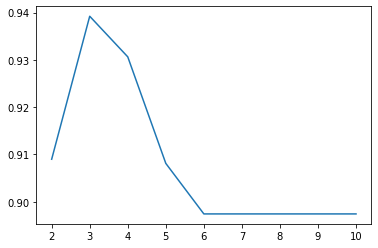

In [34]:
X = to_chin.drop(['Neighborhood'], axis=1)
sil = []
kmax = 10
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeansx = KMeans(n_clusters = k).fit(X)
  labels = kmeansx.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot (list(range(2,11)),sil)

Do the Kmeans culstering with the best value of K

In [35]:
# set number of clusters
K = 3

# run k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0], dtype=int32)

Add cluster label to dataframe.

In [36]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = to_chin.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_
to_merged.tail()

,Neighborhood,Chinese Restaurant,Cluster Labels
34,"The Annex, North Midtown, Yorkville",0.00,0
35,The Beaches,0.00,0
36,"The Danforth West, Riverdale",0.00,0
37,"Toronto Dominion Centre, Design Exchange",0.01,2
38,"University of Toronto, Harbord",0.00,0


In [37]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(df_hasilfq.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1639, 9)


,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.0,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.0,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.0,0,43.644771,-79.373306,Goose Island Brewhouse,43.647329,-79.373541,Beer Bar


Sort the values by "Cluster Label"

In [38]:
# sort the results by Cluster Labels
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13,"Garden District, Ryerson",0.01,2,43.657162,-79.378937,Scaddabush Italian Kitchen & Bar,43.658920,-79.382891,Italian Restaurant
13,"Garden District, Ryerson",0.01,2,43.657162,-79.378937,LUSH,43.653557,-79.380400,Cosmetics Shop
13,"Garden District, Ryerson",0.01,2,43.657162,-79.378937,Jack Astor's Bar & Grill,43.656019,-79.380326,Restaurant
13,"Garden District, Ryerson",0.01,2,43.657162,-79.378937,Panago,43.658258,-79.384313,Pizza Place
14,"Harbourfront East, Union Station, Toronto Islands",0.01,2,43.640816,-79.381752,Toronto Railway Museum,43.640745,-79.385981,History Museum


### 8. Clustering visualization

In [39]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(K)
ys = [i+x+(i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
to_chin["Cluster Labels"] = kmeans.labels_
to_chin.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Chinese Restaurant,Cluster Labels
0,Berczy Park,0.0,0
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0
2,"Business reply mail Processing Centre, South C...",0.0,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0
4,Central Bay Street,0.0,0


Total of neighbors each cluster

In [41]:
to_chin['Cluster Labels'].value_counts()

0    32
2     4
1     3
Name: Cluster Labels, dtype: int64

### 9. Examine Clusters

In [42]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df_neighborhoods[['Borough', 'Neighborhood']]
df_new.head()

,Borough,Neighborhood
0,Scarborough,"Malvern, Rouge"
1,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,Scarborough,"Guildwood, Morningside, West Hill"
3,Scarborough,Woburn
4,Scarborough,Cedarbrae


Cluster 1

In [43]:
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.sort_values(["Chinese Restaurant"], ascending=False)

,Borough,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,East Toronto,The Beaches,0.0,0,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
799,Downtown Toronto,Stn A PO Boxes,0.0,0,43.646435,-79.374846,Paddington's Pump,43.649035,-79.371899,Diner
779,Downtown Toronto,Stn A PO Boxes,0.0,0,43.646435,-79.374846,HI-Toronto Hostel,43.650623,-79.375190,Hostel
778,Downtown Toronto,Stn A PO Boxes,0.0,0,43.646435,-79.374846,Loblaws,43.645427,-79.369789,Grocery Store
777,Downtown Toronto,Stn A PO Boxes,0.0,0,43.646435,-79.374846,Tim Hortons,43.647761,-79.370496,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...
387,Downtown Toronto,Central Bay Street,0.0,0,43.657952,-79.387383,Krispy Kreme Doughnut Cafe,43.655772,-79.391993,Donut Shop
386,Downtown Toronto,Central Bay Street,0.0,0,43.657952,-79.387383,Winners,43.660997,-79.383599,Department Store
385,Downtown Toronto,Central Bay Street,0.0,0,43.657952,-79.387383,Est West Cafe,43.659541,-79.390637,Salad Place
384,Downtown Toronto,Central Bay Street,0.0,0,43.657952,-79.387383,Omai,43.656006,-79.392494,Japanese Restaurant


Cluster 2

In [44]:
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.sort_values(["Chinese Restaurant"], ascending=False)

,Borough,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,"North Toronto West, Lawrence Park",0.055556,1,43.715383,-79.405678,Barreworks,43.714070,-79.400109,Yoga Studio
10,Central Toronto,"North Toronto West, Lawrence Park",0.055556,1,43.715383,-79.405678,lululemon,43.713478,-79.400082,Clothing Store
1,Central Toronto,"North Toronto West, Lawrence Park",0.055556,1,43.715383,-79.405678,Civello Salon,43.715111,-79.400304,Salon / Barbershop
17,Central Toronto,"North Toronto West, Lawrence Park",0.055556,1,43.715383,-79.405678,C'est Bon,43.716785,-79.400406,Chinese Restaurant
16,Central Toronto,"North Toronto West, Lawrence Park",0.055556,1,43.715383,-79.405678,Tim Hortons,43.714894,-79.399776,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...
71,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,1,43.662301,-79.389494,Starbucks,43.659456,-79.390411,Coffee Shop
70,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,1,43.662301,-79.389494,Como En Casa,43.665160,-79.384796,Mexican Restaurant
69,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,1,43.662301,-79.389494,401 Games,43.663623,-79.384037,Hobby Shop
68,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0.030303,1,43.662301,-79.389494,Coach House Restaurant,43.664991,-79.384814,Diner


Cluster 3

In [45]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.sort_values(["Chinese Restaurant"], ascending=False)

,Borough,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown Toronto,Church and Wellesley,0.013333,2,43.665860,-79.383160,Starbucks,43.664980,-79.380510,Coffee Shop
48,Downtown Toronto,Church and Wellesley,0.013333,2,43.665860,-79.383160,Alexander Wood Statue,43.663702,-79.380301,Sculpture Garden
55,Downtown Toronto,Church and Wellesley,0.013333,2,43.665860,-79.383160,Bikram Yoga Yonge,43.668205,-79.385780,Yoga Studio
54,Downtown Toronto,Church and Wellesley,0.013333,2,43.665860,-79.383160,Ginger,43.665372,-79.380846,Vietnamese Restaurant
53,Downtown Toronto,Church and Wellesley,0.013333,2,43.665860,-79.383160,Onnki Donburi,43.669757,-79.384574,Japanese Restaurant
...,...,...,...,...,...,...,...,...,...,...
173,Downtown Toronto,"Garden District, Ryerson",0.010000,2,43.657162,-79.378937,Jack Astor's Bar & Grill,43.656019,-79.380326,Restaurant
172,Downtown Toronto,"Garden District, Ryerson",0.010000,2,43.657162,-79.378937,LUSH,43.653557,-79.380400,Cosmetics Shop
171,Downtown Toronto,"Garden District, Ryerson",0.010000,2,43.657162,-79.378937,Scaddabush Italian Kitchen & Bar,43.658920,-79.382891,Italian Restaurant
170,Downtown Toronto,"Garden District, Ryerson",0.010000,2,43.657162,-79.378937,Balzac's Coffee,43.657854,-79.379200,Coffee Shop


Average of Chinese Restaurants each Cluster

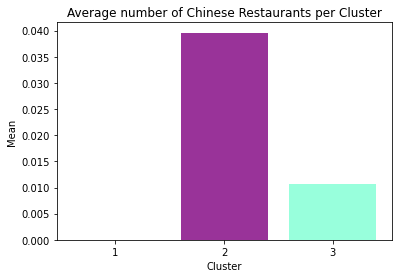

In [46]:
clusters_mean = [df_cluster1['Chinese Restaurant'].mean(),df_cluster2['Chinese Restaurant'].mean(),df_cluster3['Chinese Restaurant'].mean()]
objects = (1,2,3)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Chinese Restaurants per Cluster')

plt.show()

### 10. Observations

The best cluster to place Chinese Restaurant, based on the density of Chinese restaurant in each cluster, is Cluster 1. Cluster 1 has neighborhoods with no Chinese Restaurant, such as The Beaches and Central Bay Street. Toronto has small number of Chinese Restaurant, so I think it is a good idea to present restaurant that serve Chinese cuisine, especially in neighborhood without Chinese Restaurant to eliminate competition.